In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl
import statsmodels.stats.multicomp as ml

from scipy import stats as spstats
from matplotlib.lines import Line2D

from pipeline.python.utils import natural_keys, label_figure, convert_range
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr


from pipeline.python.classifications import bootstrap_osi as osi




In [2]:
%matplotlib notebook

In [3]:
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

In [4]:
def outline_boxplot(ax):
    # iterate over boxes to make them outlines only
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')
        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             ax.lines[j].set_color('black')
    return


# Set metadata info

In [5]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'

#### Preprocessing params
responsive_test = 'nstds'
responsive_thr = 10.0
n_stds = 2.5

#### Fit params
response_type = 'dff'
fit_thr=None

n_bootstrap_iters=1000
n_resamples = 20


#### Get fit description
fit_desc = osi.get_fit_desc(response_type=response_type, responsive_test=responsive_test,
                       responsive_thr=responsive_thr, n_stds=n_stds)
print(fit_desc)

fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [6]:
#### Set outputdir for current analysis
outdir = os.path.join(aggregate_dir, 'gratings-tuning', '%s-%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

#### Create data ID for labeling figures with data-types
data_id = '%s|%s' % (traceid, fit_desc)
print("DATA ID: %s" % data_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
DATA ID: traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [7]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

# Aggregate all tuning data

In [8]:
def get_average_tuning_over_iters(fitdf):
    means = {}
    roi = int(fitdf['cell'].unique()[0])
    for param in fitdf.columns:
        if 'theta' in param:
            meanval = np.rad2deg(spstats.circmean(np.deg2rad(fitdf[param].values % 360.)))
        else:
            meanval = fitdf[param].values.mean()
        
        means[param] = meanval
    
    return pd.DataFrame(means, index=[roi])

In [9]:
#### Get metadata
dsets = aggr.get_metadata(stimulus='gratings',  filter_by='most_cells', stimulus_only=True,
                              traceid=traceid, fov_type=fov_type, state=state)
dsets.groupby(['visual_area', 'experiment']).count()


Selecting 22 dsets


,,animalid,fov,session,fovnum
visual_area,experiment,,,,
Li,gratings,9,9,9,9
Lm,gratings,6,6,6,6
V1,gratings,7,7,7,7


In [11]:
#### Test with 1 dataset first

# animalid = 'JC091'
# session = '20191008'
# fov = 'FOV1_zoom2p0x'
# gof_thr=0.6


# bootresults, fitparams = osi.load_tuning_results(animalid, session, fov, 'combined_gratings_static', \
#                                                  traceid, fit_desc)
# rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=gof_thr)
# print("%i cells with good fits." % rmetrics.shape[0])

In [12]:
gof_thr = 0.5

In [13]:
no_fits = []
cellcounts = []
gdata = []
i = 0
for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    skey = '%s_%s' % (visual_area, '-'.join([animalid, session, fov]) )

    exp = util.Gratings(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    roi_list, _ = exp.get_responsive_cells(responsive_test=responsive_test, responsive_thr=5)
    bootresults, fitparams = exp.get_tuning(response_type=response_type,
                                           responsive_test=responsive_test,
                                           responsive_thr=responsive_thr,
                                           n_stds=n_stds,
                                           n_bootstrap_iters=n_bootstrap_iters,
                                           n_resamples=n_resamples,
                                           n_processes=1, make_plots=True)
    
    passrois = sorted([k for k, v in bootresults.items() if any(v.values())])
    
    # Get good fits
    rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=gof_thr)
    if rmetrics is None:
        no_fits.append(skey)
        
        continue
    
    #cellcounts[skey] = (rmetrics.shape[0], len(roi_list))
    cellcounts.append(pd.DataFrame({'datakey': '_'.join([animalid, session, fov]),
                                    'visual_area': visual_area,
                                    'responsive_cells': len(roi_list),
                                    'tuned_cells': len(passrois),
                                    'gof_cells': len(rmetrics)}, index=[i]))
    
    meandf = pd.concat([rmetrics_by_cfg.groupby(['cell']).get_group(roi).sort_values(by=['asi','dsi'],ascending=False).iloc[0]\
           for roi in rmetrics['cell'].unique()], axis=1).T

    ncells = meandf.shape[0]
    meandf['visual_area'] = [visual_area for _ in range(ncells)]
    meandf['animalid'] = [animalid for _ in range(ncells)]
    meandf['session'] = [session for _ in range(ncells)]
    meandf['fov'] = [fov for _ in range(ncells)]
    
    gdata.append(meandf)
    
    i += 1
    
cellcounts = pd.concat(cellcounts, axis=0)
gdata = pd.concat(gdata, axis=0)


print("Datasets with NO fits found:")
for s in no_fits:
    print(s)

[JC090|20190605|FOV1_zoom2p0x] creating gratings object
... getting responsive cells (test: nstds, thr: 5.00')
... loading stats
... getting OSI results: fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
... loading existing fits.
... 6 of 25 cells pass GoF thr 0.50
[JC091|20190602|FOV1_zoom2p0x] creating gratings object
... getting responsive cells (test: nstds, thr: 5.00')
... loading stats
... getting OSI results: fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
... loading existing fits.
... 16 of 69 cells pass GoF thr 0.50
[JC091|20190614|FOV1_zoom2p0x] creating gratings object
... getting responsive cells (test: nstds, thr: 5.00')
... loading stats
... getting OSI results: fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
... loading existing fits.
... 14 of 49 cells pass GoF thr 0.50
[JC091|20191008|FOV1_zoom2p0x] creating gratings object
... getting responsive cells (test: nstds, thr: 5.00')
... loading stats
... getting OSI results: fit-dff_re

In [149]:
rmetrics

,asi,cell,dsi,gof,r2,r2comb,response_null,response_offset,response_pref,sigma,theta_pref
84,0.512486,84.0,0.121548,0.794739,0.900882,0.858558,0.293767,-0.090918,0.333137,42.898210,9.412508
91,0.194902,91.0,0.058618,0.666159,0.846772,0.743065,0.262581,0.117508,0.334690,29.645511,279.179339
107,0.148042,107.0,0.068917,0.642901,0.829892,0.762052,0.165400,0.096868,0.239316,35.495459,101.278224
110,0.510911,110.0,0.178227,0.886706,0.943191,0.946109,0.141311,0.002052,0.187748,31.537179,357.441196
150,0.129520,150.0,0.059802,0.708703,0.851353,0.927363,0.083826,0.168052,0.180129,28.460366,133.659052
173,0.569934,173.0,0.190030,0.898410,0.945985,0.965616,0.137462,0.007041,0.186559,27.908736,357.405664
234,0.571011,234.0,0.107915,0.887152,0.936847,0.945644,0.400833,-0.107274,0.474921,40.541205,288.347417
237,0.346439,237.0,0.273112,0.834718,0.907523,0.931390,0.154017,0.089265,0.409491,30.743793,14.495402
276,0.206813,276.0,0.077255,0.713844,0.902622,0.718328,0.225374,-0.064971,0.259187,50.369826,286.298099
313,0.243642,313.0,0.114191,0.834540,0.915646,0.925973,0.132252,0.074934,0.196153,31.254833,324.777484


In [14]:
gdata.groupby(['visual_area']).count()

,asi,cell,dsi,gof,r2,r2comb,response_null,response_offset,response_pref,sigma,theta_pref,animalid,session,fov
visual_area,,,,,,,,,,,,,,
Li,57,57,57,57,57,57,57,57,57,57,57,57,57,57
Lm,158,158,158,158,158,158,158,158,158,158,158,158,158,158
V1,228,228,228,228,228,228,228,228,228,228,228,228,228,228


In [15]:
cellcounts['gof_over_responsive'] = cellcounts['gof_cells'].astype(float) / cellcounts['responsive_cells']
cellcounts['tuned_over_responsive'] = cellcounts['tuned_cells'].astype(float) / cellcounts['responsive_cells']
cellcounts['reliably_tuned'] = cellcounts['gof_cells'].astype(float) / cellcounts['tuned_cells']


In [16]:
# fracs = []
# for visual_area in visual_areas:
    
#     sk = [k for k, v in cellcounts.items() if k.split('_')[0]==visual_area \
#          and '-'.join(k.split('_')[1].split('-')[0:2]) not in excluded_sessions]
#     total = np.sum([cellcounts[k][0] for k in sk])
#     print "%s: %i" % (visual_area, total)
    
#     fvs = [float(v[0])/float(v[1]) for k, v in cellcounts.items() if k.split('_')[0]==visual_area]
#     fracs.append(pd.DataFrame({'fraction': fvs,
#                   'visual_area': [visual_area for _ in range(len(fvs))]}))
# fracs = pd.concat(fracs)

In [17]:
dstdir = os.path.join(outdir, 'general_stats')
if not os.path.exists(dstdir):
    os.makedirs(dstdir)
print("saving figures to:\n%s" % dstdir)

saving figures to:
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats


# Fraction tuned 

<IPython.core.display.Javascript object>


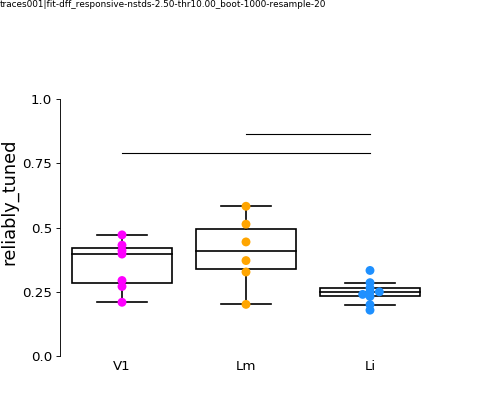

********* [reliably_tuned] Mann-Whitney U test(mc=holm) **********
[('V1', 'Lm')] Statistics=16.000, p=0.260, ... Same distribution (fail to reject H0)
[('V1', 'Li')] Statistics=10.000, p=0.013, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=8.000, p=0.015, ... Different distribution (reject H0)
0.72
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'fraction-tuned_reliably_tuned_gof-0.50')


In [20]:
#fraction_plot = 'gof_over_responsive'
#fraction_plot = 'tuned_over_responsive'
fraction_plot = 'reliably_tuned'

multi_comp_test = 'holm'

ylim = 1 #
fig, ax = pl.subplots(figsize=(6,5))
ax = sns.boxplot(x="visual_area", y=fraction_plot, data=cellcounts, fliersize=0,
                 palette=area_colors, ax=ax, order=visual_areas) #, alpha=0.7) #,\
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))

outline_boxplot(ax)
sns.swarmplot(x='visual_area', y=fraction_plot, data=cellcounts, ax=ax, 
              color='k', s=8, marker='o',order=visual_areas, palette=area_colors)
ax.tick_params(which='both', axis='x', length=0)
ax.set_xlabel('')


stats_fraction_tuned, ax = aggr.plot_mannwhitney(cellcounts, metric=fraction_plot, ax=ax, 
                                                multi_comp_test=multi_comp_test)


ymax = round(ax.get_ylim()[-1], 1)
ax.set_ylim([0, ylim+0.2])
ax.set_yticks(np.linspace(0, ylim, 5))
ax.set_yticklabels([round(i, 2) for i in np.linspace(0, ylim, 5)])
sns.despine(bottom=True, trim=True)


label_figure(fig, data_id)

# pl.subplots_adjust(top=0.8)

figname = 'fraction-tuned_%s_gof-%.2f' % (fraction_plot, gof_thr)
pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print(dstdir, figname)

#### Stats

In [21]:
c1 = cellcounts[cellcounts['visual_area']=='V1'][fraction_plot].values
c2 = cellcounts[cellcounts['visual_area']=='Lm'][fraction_plot].values
c3 = cellcounts[cellcounts['visual_area']=='Li'][fraction_plot].values

# Shapiro-Wilk normality test 
print("Shapiro-Wilk normality:", spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) )

# Levene variance test  
print(spstats.levene(c1, c2, c3))

F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])

# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

('Shapiro-Wilk normality:', (0.9276056289672852, 0.530724287033081), (0.987891674041748, 0.9834109544754028), (0.971199095249176, 0.9047861099243164))
LeveneResult(statistic=3.4188249721961492, pvalue=0.053920711484245147)
F statistic = 5.678 and probability p = 0.012
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm    0.1587   0.0333 0.2841  True 
  Li     V1    0.1069   -0.013 0.2268 False 
  Lm     V1   -0.0518  -0.1842 0.0806 False 
--------------------------------------------


# Visualize

In [22]:
def compare_tuning_metric(df, metric='ASI', cdf=False, ax=None, area_colors=None, show_legend=True, alpha=1):
    if ax is None:
        fig, ax = pl.subplots(figsize=(6,4))
        fig.patch.set_alpha(1)
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
       

    for visual_area, tmpd in df.groupby(['visual_area']):
        nrats = len(tmpd['animalid'].unique())
        nfovs = len(list(set(['-'.join([a, s, v]) for a, s, v in tmpd[['animalid', 'session', 'fov']].values])))
        ncells_total = tmpd.shape[0]
        values = tmpd[metric].values
        weights = np.ones_like(values)/float(len(values))
        ax.hist(values, 
                cumulative=cdf,
                label='%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells_total),
                color=area_colors[visual_area],
                histtype='step', alpha=alpha, lw=3,
                normed=0, weights=weights)
    if show_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(metric)
    if cdf:
        ax.set_ylabel('CDF')
    else:
        ax.set_ylabel('fraction')

## DistN ASI/DSI

<IPython.core.display.Javascript object>


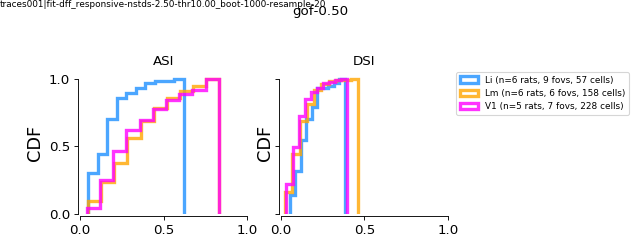

asi-dsi_best-config-out-of-all_gof-0.50_cdf


In [23]:
#gof = 0.66
cdf = True
alpha = 0.8
filter_gof = True

roi_str = 'gof-%.2f' % gof_thr if filter_gof else 'all-cells'
rdata = gdata[gdata['gof'] >= gof_thr] if filter_gof else gdata.copy()


fig, axes = pl.subplots(1,2, sharex=True, sharey=True, figsize=(8,3))
fig.patch.set_alpha(1)

ax = axes[0]
ax.set_title('ASI')
compare_tuning_metric(rdata, metric='asi', cdf=cdf, area_colors=area_colors, ax=ax, show_legend=False, alpha=alpha)
ax = axes[1]
compare_tuning_metric(rdata, metric='dsi', cdf=cdf, area_colors=area_colors, ax=ax, alpha=alpha)
ax.set_title('DSI')

pl.subplots_adjust(wspace=0.2, right=0.7, top=0.7)
fig.suptitle(roi_str)
for ax in axes:
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    sns.despine(ax=ax, trim=True, offset=2)
    
    
label_figure(fig, data_id)
figname = 'asi-dsi_best-config-out-of-all_%s_%s' % (roi_str, 'cdf' if cdf else 'hist')
pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print figname

In [185]:
aggregate_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas'

# Set output dir for aggregate figures

<IPython.core.display.Javascript object>


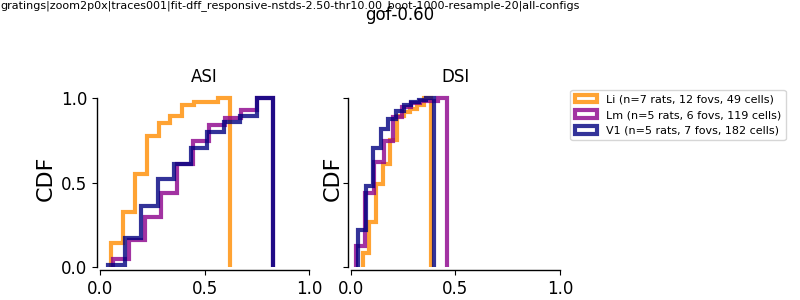

asi-dsi_all-configs-best_gof-0.60_cdf


In [216]:
#gof = 0.66
cdf = True
alpha = 0.8
filter_gof = True

if filter_gof:
    roi_str = 'gof-%.2f' % gof_thr
    rdata = gdata[gdata['gof'] >= gof_thr]
else:
    roi_str = 'all-cells'
    rdata = gdata.copy()

fig, axes = pl.subplots(1,2, sharex=True, sharey=True, figsize=(8,3))
fig.patch.set_alpha(1)

ax = axes[0]
ax.set_title('ASI')
compare_tuning_metric(rdata, metric='asi', cdf=cdf, area_colors=area_colors, ax=ax, show_legend=False, alpha=alpha)
ax = axes[1]
compare_tuning_metric(rdata, metric='dsi', cdf=cdf, area_colors=area_colors, ax=ax, alpha=alpha)
ax.set_title('DSI')

pl.subplots_adjust(wspace=0.2, right=0.7, top=0.7)
fig.suptitle(roi_str)
for ax in axes:
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    sns.despine(ax=ax, trim=True, offset=2)
    
    
label_figure(fig, data_identifier)
figname = 'asi-dsi_all-configs-best_%s_%s' % (roi_str, 'cdf' if cdf else 'hist')
pl.savefig(os.path.join(destdir, '%s.svg' % figname))
print figname

In [182]:
len(list(set(['-'.join([a, s, v]) for a, s, v in rdata[['animalid', 'session', 'fov']].values])))

19

In [194]:
rdata.shape

(350, 15)

In [195]:
gdata.shape

(350, 15)

## Preferred theta

In [24]:
import matplotlib.patches as mpatches


<IPython.core.display.Javascript object>


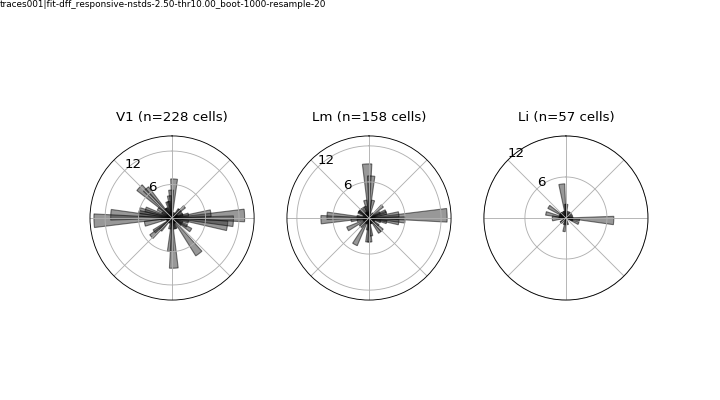

In [25]:
fig = pl.figure(figsize=(9,5))
fig.patch.set_alpha(1)
ylim = 12
nradii=3
bar_width=10
yticks = np.linspace(0, ylim, nradii)
    
#ymax = 1.5
for vi, visual_area in enumerate(visual_areas):
    g = gdata.groupby(['visual_area']).get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g.copy()

    degrees = tmpg['theta_pref'].values
    #degrees = tmpg['tested_theta'].values

    radians = np.rad2deg(degrees)
    
    #radians = np.deg2rad(degrees)

    bin_size = 5. #45.
    a, b =np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size))
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])

    ax = pl.subplot(1,3,vi+1, projection='polar')
    ax.bar(centers, a, width=np.deg2rad(bar_width), bottom=0.0, color='.2', alpha=0.5, edgecolor='k')
    ax.set_theta_zero_location("N")
    #ax.set_theta_direction(-1)
#     pl.show()
    
#     if a.max() < ylim:
#         plot_lim = a.max() + bin_size
#         yticks = [i for i in yticks if i<=plot_lim]
#     else: 
#         plot_lim = ylim
    plot_lim = ylim
    #ax.set_ylim([0, plot_lim])

    ax.set_yticks(yticks)
    ax.tick_params(axis='both', which='y', labelsize=8, pad=6, )
    ax.set_yticklabels(['' if yi==0 else int(yv) for yi, yv in enumerate(yticks)])
    #ax.set_yticklabels(yticks)
    ax.set_rlabel_position(45)
    ax.set_xticklabels('')
    
    ax.set_title('%s (n=%i cells)' % (visual_area, tmpg.shape[0]), loc='center', fontsize=12)
    
pl.subplots_adjust(wspace=0.2, top=0.8)

label_figure(fig, data_id)

figname = 'distn_preferred_thetas_gof-%.2f' % gof_thr
pl.savefig(os.path.join(dstdir, '%s.svg' % figname))

## Preferred theta, scale radius by response value(dff)

<IPython.core.display.Javascript object>


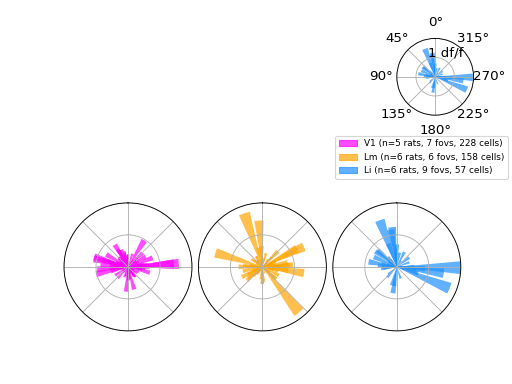

distn_preferred_thetas_scale-dff_gof-0.50


In [26]:
fig = pl.figure()
fig.patch.set_alpha(1)
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
lbs = []
ylim = 1.8 #.0

#ymax = 1.5
for vi, visual_area in enumerate(visual_areas):
    g = gdata.groupby(['visual_area']).get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g.copy()
    radii = tmpg['response_pref'] #/tmpg['response_pref'].max()
    thetas = np.deg2rad( np.arange(0, 360, 45) )
    widths = np.deg2rad( tmpg['theta_pref'].values )

    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.count()[0]
    bars = ax.bar(widths, radii, width=.2, bottom=0.0, color=area_colors[visual_area], lw=2)
    for r,bar in zip(radii, bars):
        bar.set_alpha(0.7)
    ax.set_theta_zero_location("N")
    ax.set_xticks(thetas)
    ax.set_xticklabels([''])
    
    ax.set_ylim([0, ylim])
    yticks = np.linspace(0, ylim, 3)
    ax.set_yticks(yticks)
    #ax.set_yticks([0, 1.0, 1.5, 2.0])
    ax.set_yticklabels(['', '', ''])

    #ax.set_ylabel('dff')
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(top=0.5, wspace=0.05)
# Legends
leg = fig.add_axes([0.6, 0.7, 0.5, .2], polar=True)
leg.set_theta_zero_location("N")
leg.set_ylim([0, ylim])
leg.set_yticks(yticks)

leg.set_yticklabels(['', '1 df/f', '', ''])
bars = leg.bar(widths, radii, width=.2, bottom=0.0, color=area_colors[visual_area], lw=2)
for r,bar in zip(radii, bars):
    bar.set_alpha(0.7)
leg.set_theta_zero_location("N")


legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.7)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(1.5, -0.55), loc='right', ncol=1, handles=legend_handles, fontsize=8)

    
#ax.set_ylabel('dff')
figname = 'distn_preferred_thetas_scale-%s_gof-%.2f' % (response_type, gof_thr)

pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print figname

<IPython.core.display.Javascript object>


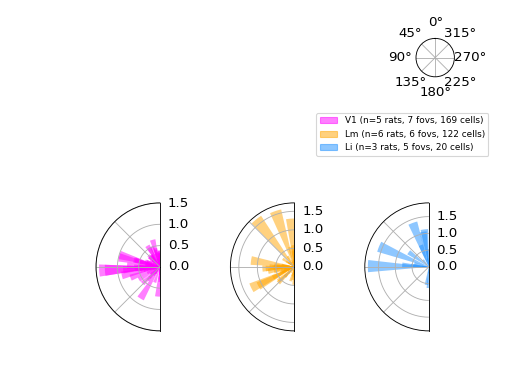

In [27]:
fig = pl.figure()
fig.patch.set_alpha(1)
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
lbs = []
for vi, visual_area in enumerate(visual_areas):
    g = gdata.groupby(['visual_area']).get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g[g['asi']>=0.2]
    radii = tmpg['response_pref'] #/tmpg['response_pref'].max()
    thetas = np.deg2rad(np.arange(0, 180+45, 45))
    widths = np.deg2rad(tmpg['theta_pref'] % 180.)

    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.count()[0]
    bars = ax.bar(widths, radii, width=.2, bottom=0.0, color=area_colors[visual_area])
    for r,bar in zip(radii, bars):
        bar.set_alpha(0.5)
    ax.set_theta_zero_location("N")
    ax.set_xticks(thetas)
    ax.set_xticklabels([''])
    ax.set_xlim([thetas[0], thetas[-1]])
    #ax.set_yticks(np.linspace(0, 1, 5))
    #ax.set_yticklabels(['']) #, '', 1])
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(top=0.5, wspace=0.05)
# Legends
leg = fig.add_axes([0.8, 0.8, 0.1, 0.1], polar=True)
leg.set_yticks([])
leg.set_theta_zero_location("N")

legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.5)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(2, -1.5), loc='right', ncol=1, handles=legend_handles, fontsize=8)

# figname = 'AS-preferrd-thetas_all-configs-best_%s' % (roi_str)
# pl.savefig(os.path.join(destdir, '%s.png' % figname))
# print figname

In [53]:
thetas

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165])

In [28]:
tested_values = np.linspace(0, 360-45., 8)
print(tested_values)
tested_thetas = list(tested_values.copy())
tested_thetas.append(360)

tested_thetas = np.array(tested_thetas)

gdata['tested_theta'] = [tested_thetas[np.where(np.abs(t-tested_thetas)==np.min(np.abs(t-tested_thetas)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
tested_thetas = tested_thetas[0:-1]

[   0.   45.   90.  135.  180.  225.  270.  315.]


In [29]:
for t in gdata['theta_pref']:
    closest_match = int(tested_thetas[np.where(np.abs(t-tested_thetas)== np.min(np.abs(t-tested_thetas)))])
    print round(t,2), closest_match

19.75 0
48.86 45
77.39 90
53.88 45
85.46 90
41.69 45
279.26 270
97.14 90
269.76 270
75.78 90
130.27 135
7.06 0
270.94 270
3.55 0
38.36 45
9.79 0
183.98 180
264.99 270
94.83 90
0.27 0
357.92 315
266.39 270
137.16 135
249.15 270
164.95 180
59.74 45
247.9 270
198.44 180
89.1 90
262.32 270
5.53 0
20.05 0
359.68 315
290.17 270
9.14 0
172.75 180
6.83 0
266.38 270
252.99 270
66.59 45
333.0 315
80.18 90
55.18 45
258.66 270
79.82 90
268.9 270
61.46 45
306.84 315
348.51 315
171.66 180
266.12 270
96.81 90
58.56 45
324.06 315
266.79 270
128.76 135
269.28 270
151.33 135
293.52 315
81.14 90
279.52 270
92.52 90
55.29 45
193.15 180
270.15 270
153.64 135
150.22 135
137.27 135
145.39 135
155.45 135
273.24 270
16.88 0
345.42 315
150.36 135
358.15 315
272.93 270
1.94 0
89.66 90
219.05 225
292.26 270
355.5 315
353.97 315
139.69 135
22.44 0
270.25 270
0.65 0
90.01 90
140.57 135
202.27 180
271.98 270
278.26 270
107.44 90
84.72 90
134.92 135
4.28 0
64.17 45
297.99 315
294.75 315
312.51 315
286.14 270
127.14 1

<IPython.core.display.Javascript object>


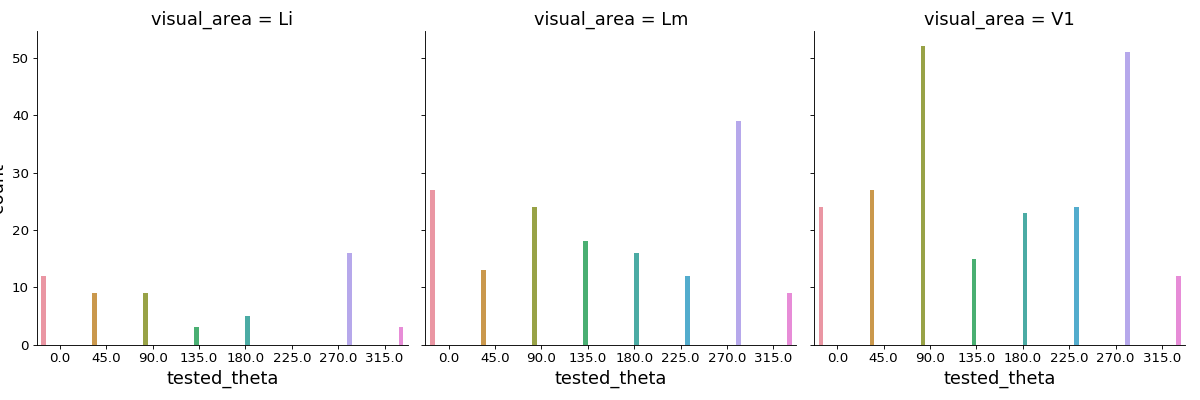

In [30]:
sns.catplot('tested_theta', col='visual_area', data=gdata, 
            hue='tested_theta', kind='count')

In [332]:
pref_thetas.shape

(179,)